In [26]:
!pip install albumentations

  Using cached albumentations-1.1.0-py3-none-any.whl (102 kB)
  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (47.8 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import numpy as np
import albumentations as A
import torch.optim as optim
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms
from PIL import Image as im
from tqdm.notebook import tqdm_notebook
import torch.nn.functional as F
from PIL import Image
import os
import segmentation_models_pytorch as smp

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
ti = os.listdir("interiitdata/training2/images")
ti = sorted(ti)

In [43]:
tl = os.listdir("interiitdata/training2/labels")
tl = sorted(tl)

In [44]:
train_transforms = A.Compose(
        [
            # A.Resize(height=128, width=128),
            A.Rotate(limit=60, p=0.6),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(
                mean=0.0,
                std=1.0,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
    [
        A.Resize(height=128, width= 128),
        A.Normalize(
            mean = 0.0,
            std = 1.0, 
            max_pixel_value = 255.0,
        ),
        ToTensorV2(),
    ]
)

In [82]:
class RoadDataset(torch.utils.data.Dataset):
    def __init__(self,path, xp_lis, yp_lis = None, transforms = None):
        self.path = path
        self.xplis = xp_lis
        self.yplis = yp_lis
        self.transforms = transforms

    def __len__(self):
        return len(self.xplis)

    def __getitem__(self, idx: int):
        i = Image.open(f"{self.path}/images/{self.xplis[idx]}")
        i = i.resize((128, 128))
        i = np.asarray(i)
        if(i.shape[0]==3 or i.shape[1]==3 or i.shape[2]==3):
            li = [eh for eh in i]
            li.append(np.ones(128, 128))
            i = np.stack(li)
        
        if(self.yplis is not None):
            l = Image.open(f"{self.path}/labels/{self.yplis[idx]}")
            l = l.resize((128, 128))
            l = (np.asarray(l) > 0)
            l = l.sum(axis=2)
            l = (l>0).astype(np.float32)
        # l = torch.tensor(l)
        # l = l/255
        
            if self.transforms is not None:
                augmentations = self.transforms(image=i, mask=l)

                i = augmentations["image"]
                l = augmentations["mask"]
        
        elif self.transforms is not None:
            augmentations = self.transforms(image=i)
            i = augmentations["image"]
        
        if(self.yplis is not None): return i, l
        
        else: return i

In [83]:
trainset = RoadDataset("interiitdata/training2" ,ti, tl, train_transforms)

In [84]:
train_loader = DataLoader(dataset = trainset, batch_size = 4, shuffle=True, num_workers=0)

In [94]:
# imm = trainset[20]
# fig, ax = plt.subplots(1, 2, figsize=(20, 4))
# ax[0].imshow(imm[0][2])
# ax[1].imshow(imm[1])

In [95]:
# ti3 = os.listdir("interiitdata/training3/images")
# ti3 = sorted(ti3) 
# tl3 = os.listdir("interiitdata/training3/labels")
# tl3 = sorted(tl3)

In [96]:
# trainset3 = RoadDataset(ti3, tl3, train_transforms)

In [97]:
# ind = 20
# ts = trainset[ind]
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].imshow(ts[0][1, :, :])
# ax[1].imshow(ts[1])

In [98]:
# model = smp.Unet(
#     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# ).to(device)

In [99]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [100]:
# def test():
#     x = torch.randn((2, 4, 128, 128))
#     model = UNET(in_channels=4, out_channels=1)
#     preds = model(x)
#     print(preds.shape)
#     assert preds.shape[0] == x.shape[0]
#     assert preds.shape[2] == x.shape[2]
#     assert preds.shape[3] == x.shape[3]
    
# test()

In [101]:
torch.backends.cudnn.benchmark=True

In [102]:
model = UNET(in_channels = 4, out_channels = 1).to(device)

loss_fn = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

In [103]:
torch.cuda.empty_cache() 

In [105]:
model.load_state_dict(torch.load("unet72imagestrainedweights.pt"))

<All keys matched successfully>

In [106]:
torch.cuda.empty_cache()

In [107]:
from tqdm.notebook import tqdm

In [108]:
losslis = []

In [121]:
optimizer = optim.Adam(model.parameters(), lr = 3e-6)

In [122]:
epochs = 100
batch_size = 8
loadtq = tqdm(range(epochs))
for epoch in loadtq:
    for i in train_loader:
        x = i[0].to(device)
        # x = x.permute(0, 3, 1, 2).to(device)
        # y = lablis[i:i+batch_size].to(device)
        y = i[1].to(device).type(torch.float32)
        with torch.cuda.amp.autocast():
            predictions = model(x)
            predictions = predictions.squeeze()
            loss = loss_fn(predictions, y)
            loss = loss.to(device)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losslis.append(loss.detach().to("cpu"))
        loadtq.set_postfix(loss=loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

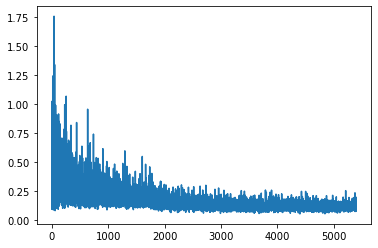

In [123]:
plt.plot(losslis)

/tmp/ipykernel_369/2486110637.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 3, figsize=(12, 4))


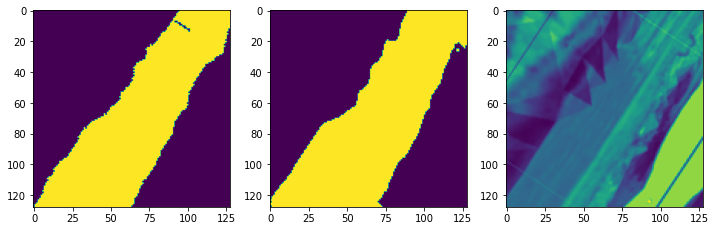

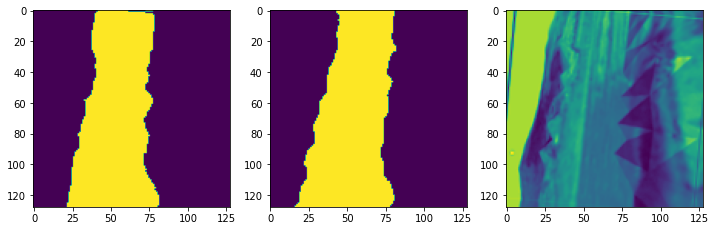

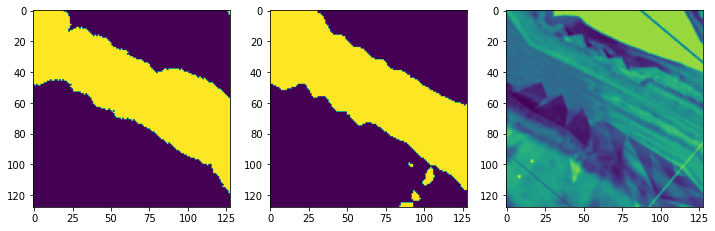

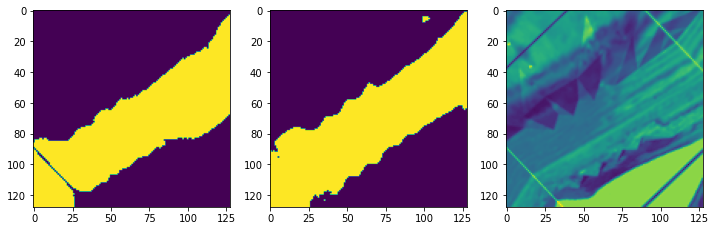

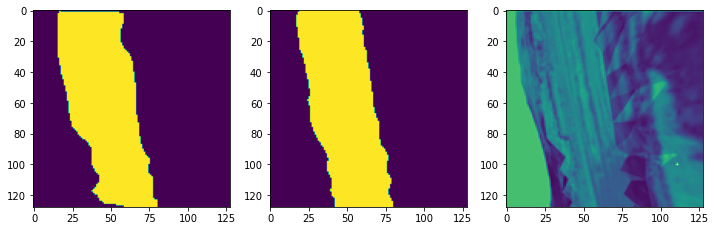

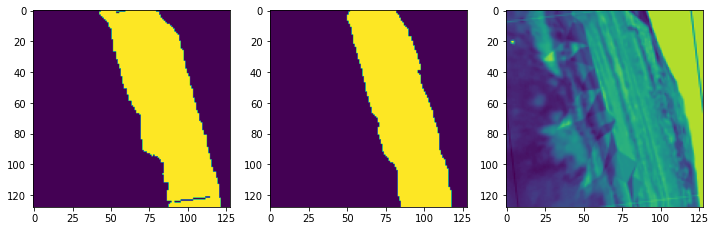

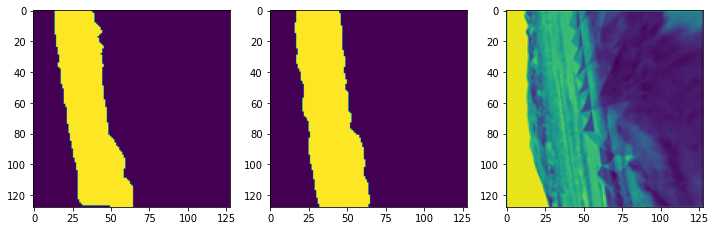

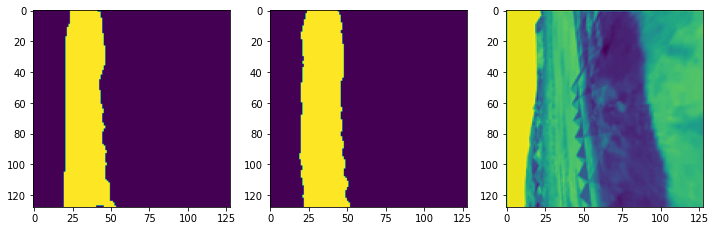

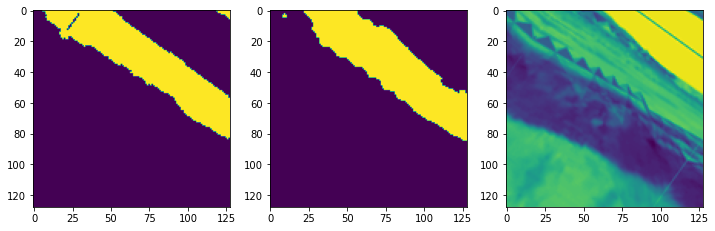

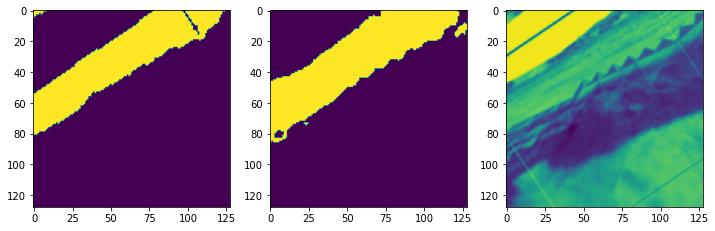

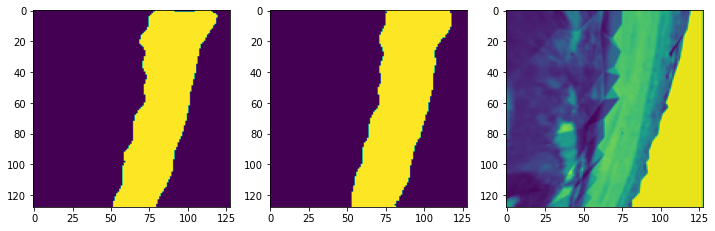

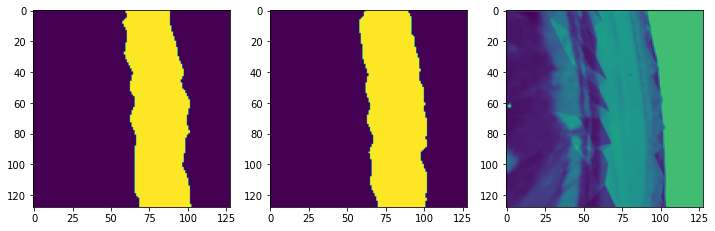

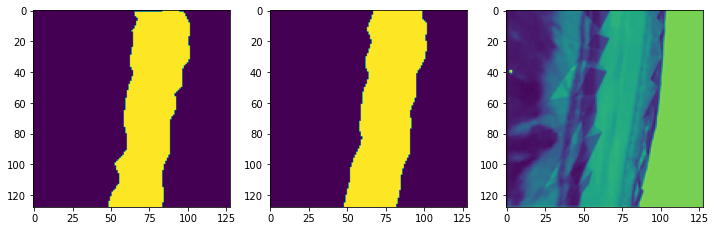

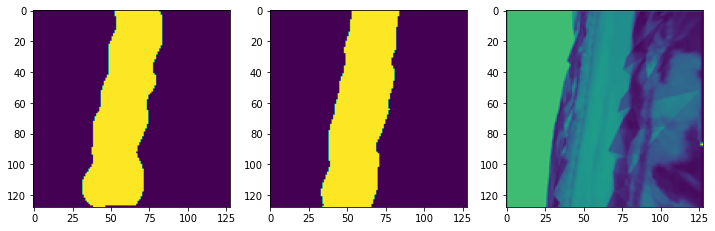

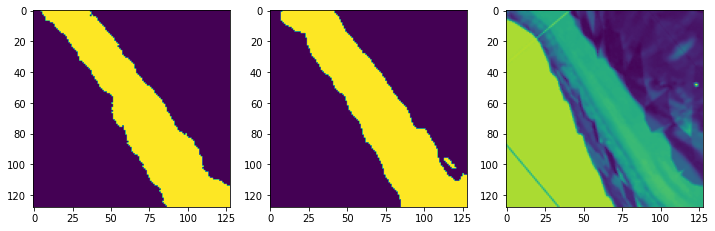

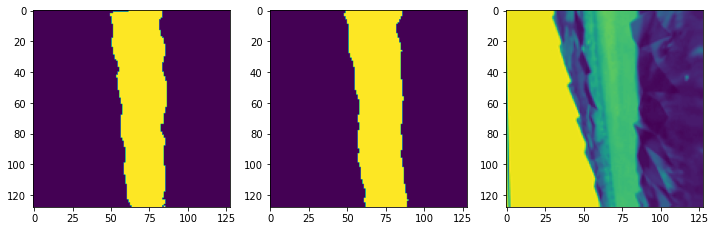

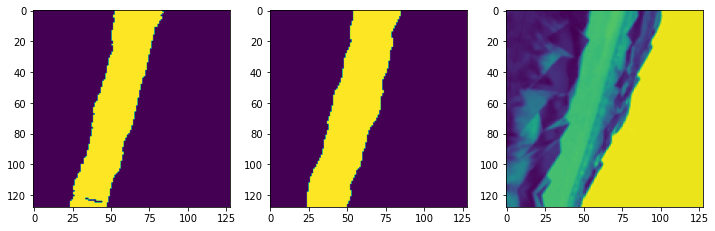

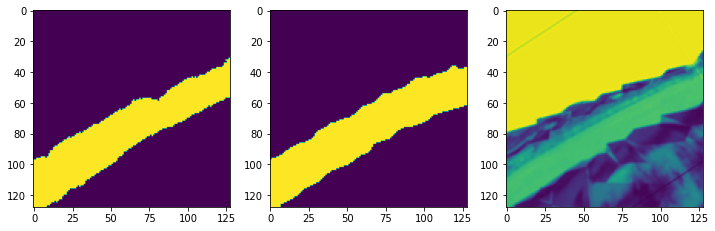

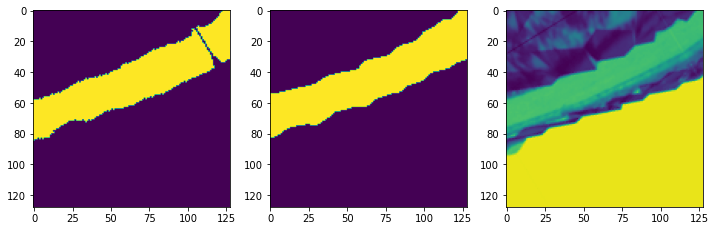

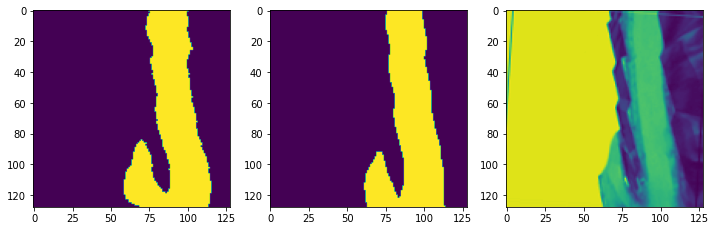

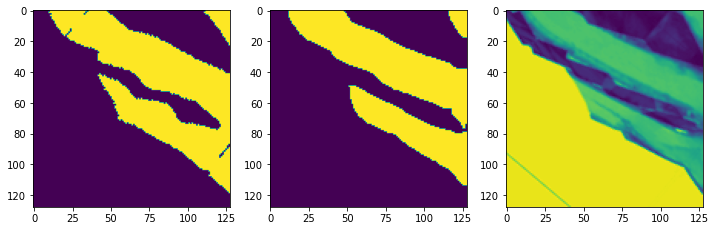

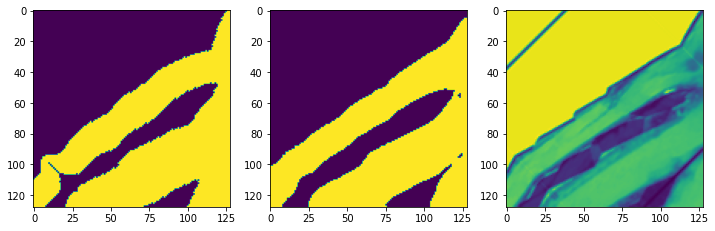

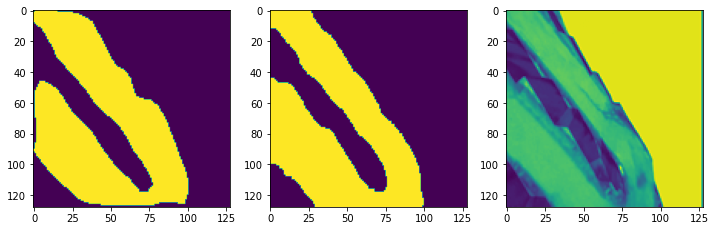

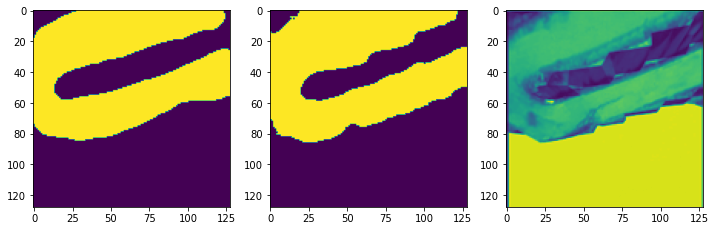

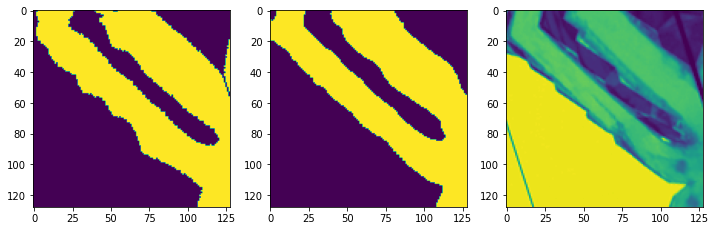

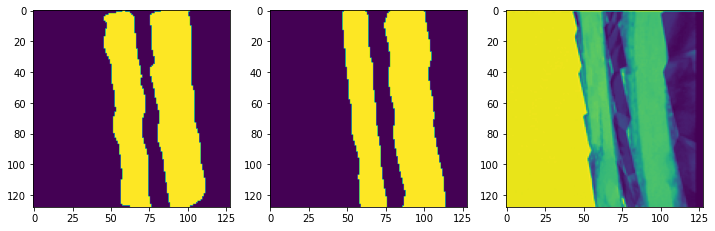

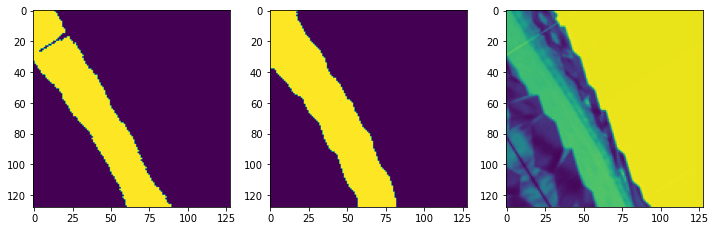

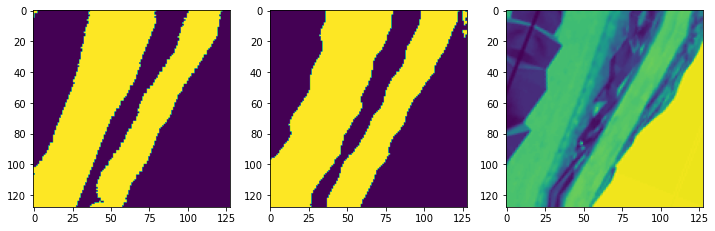

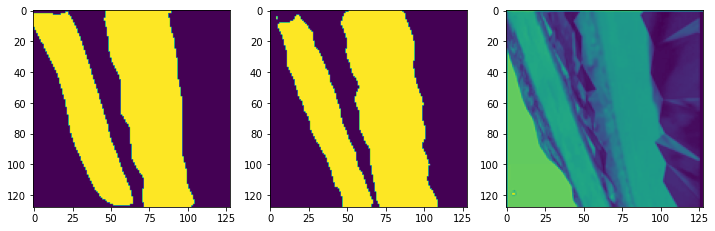

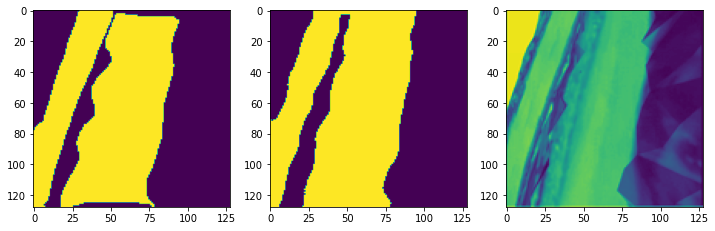

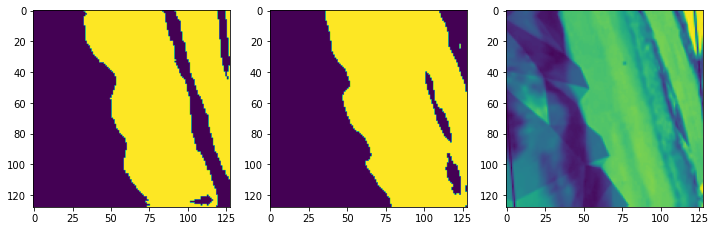

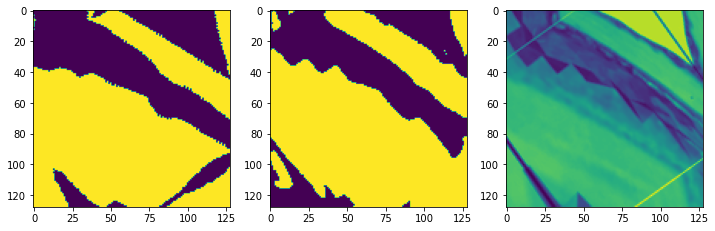

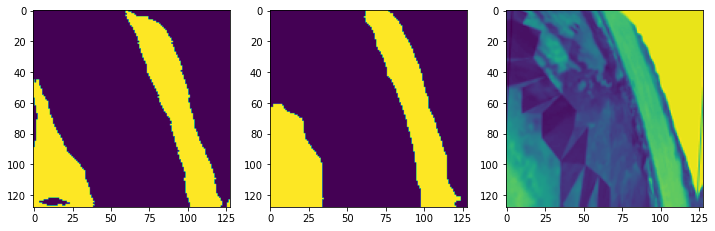

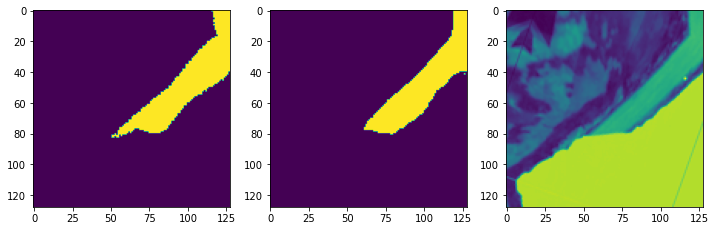

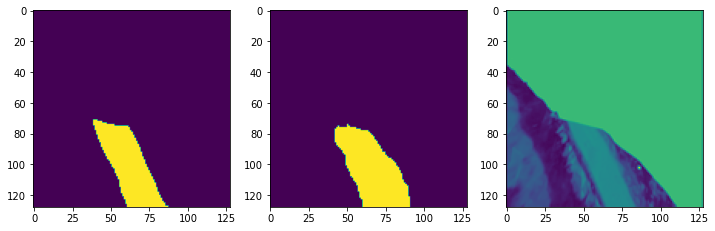

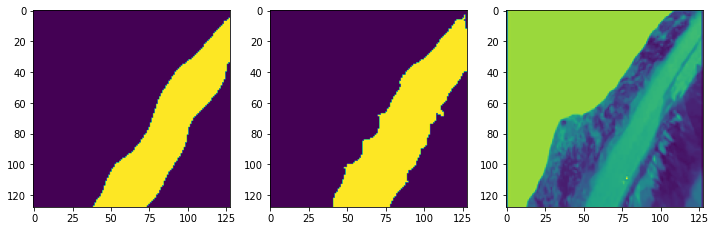

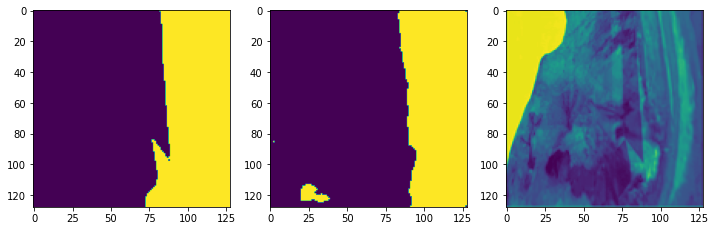

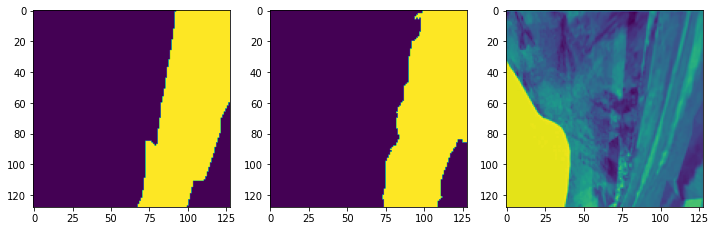

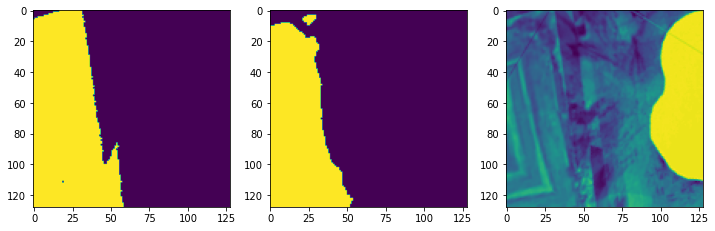

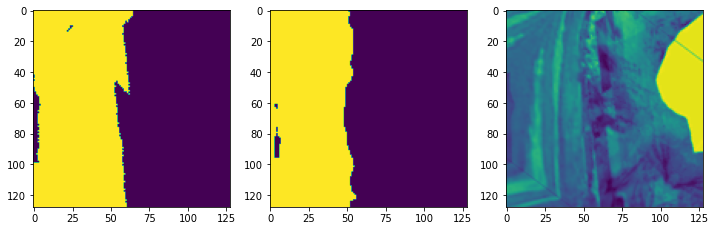

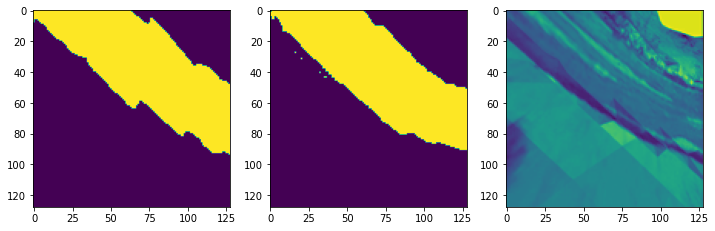

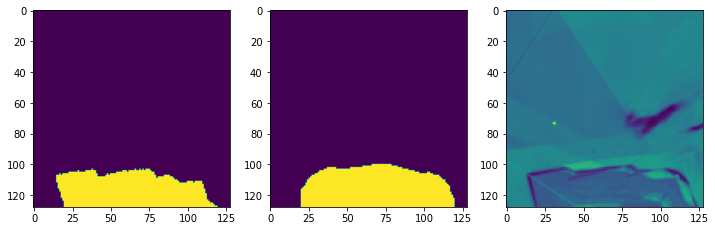

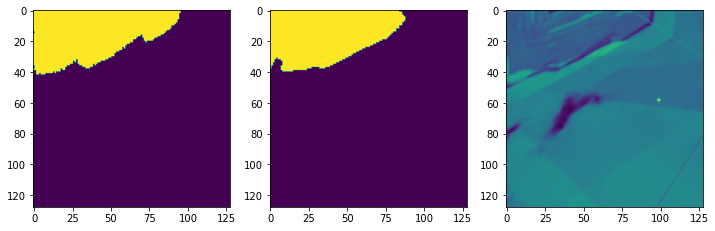

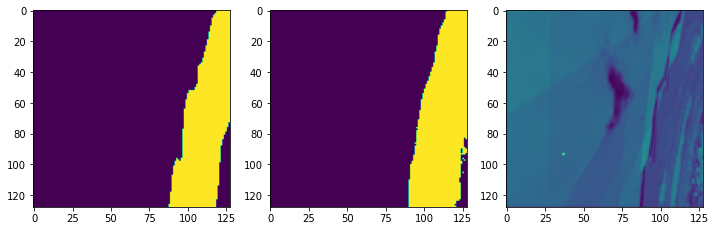

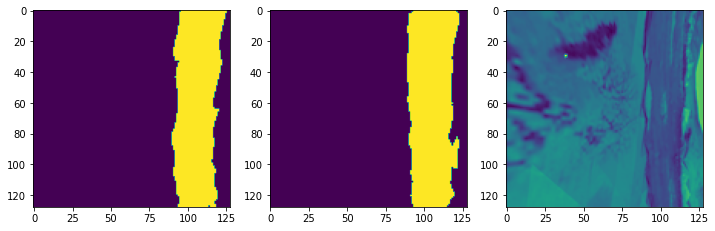

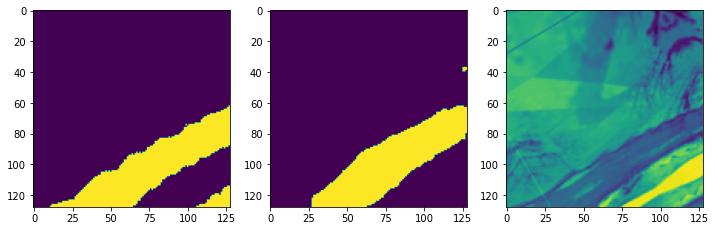

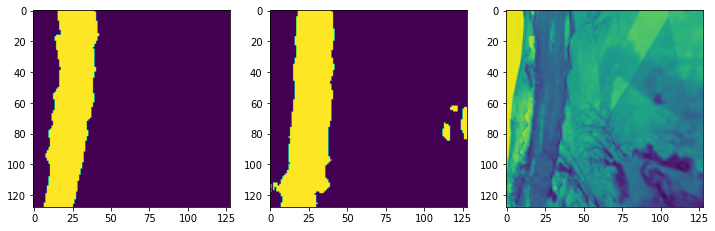

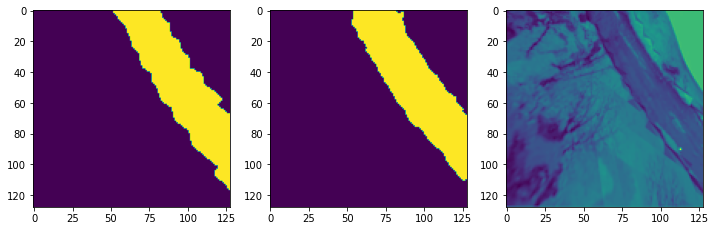

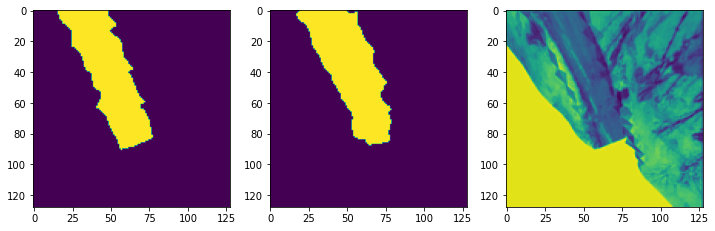

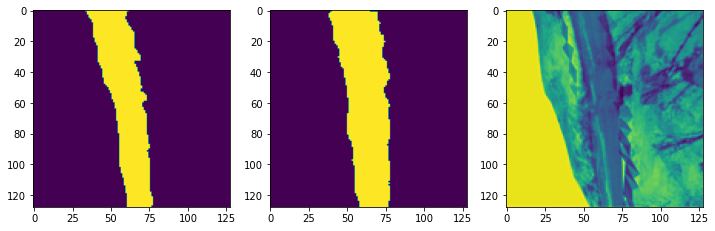

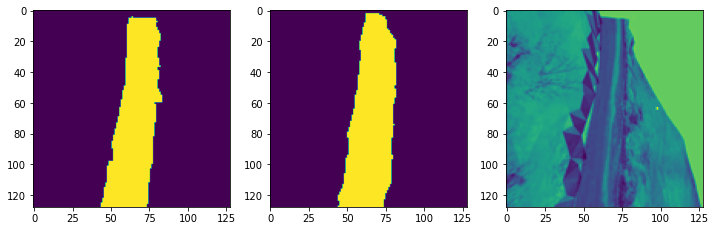

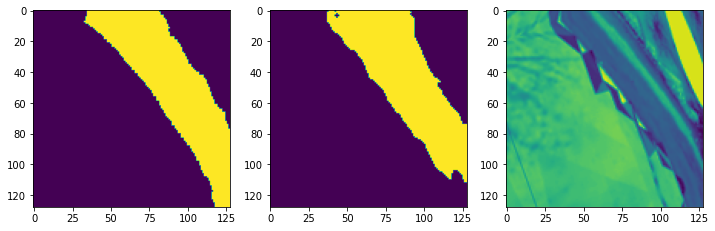

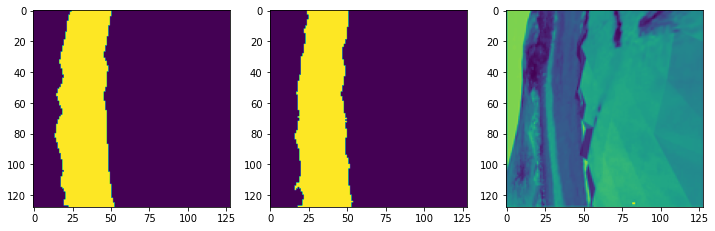

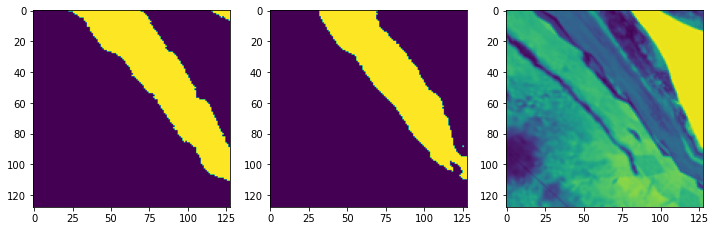

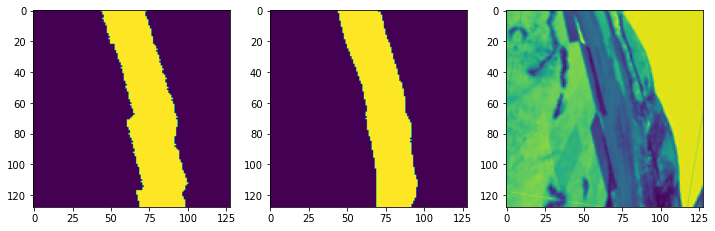

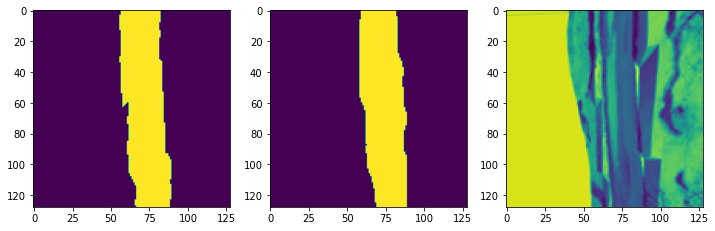

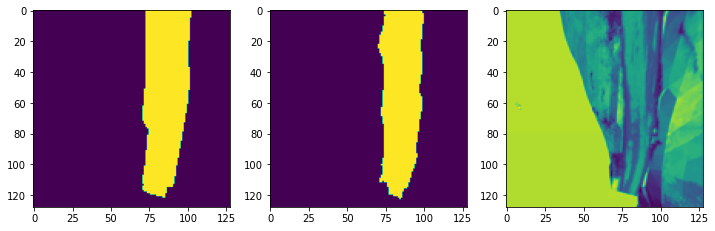

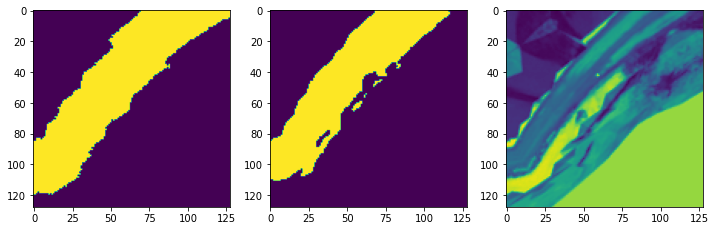

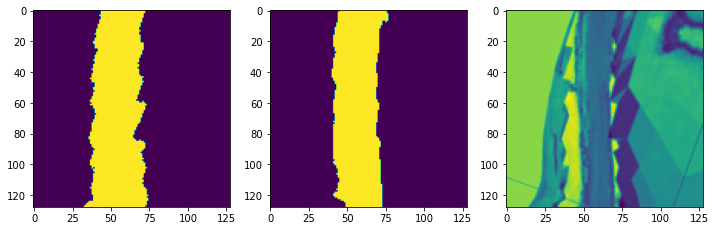

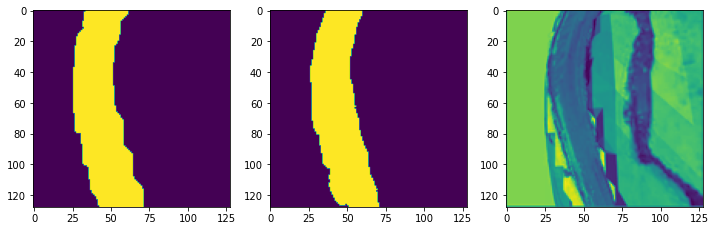

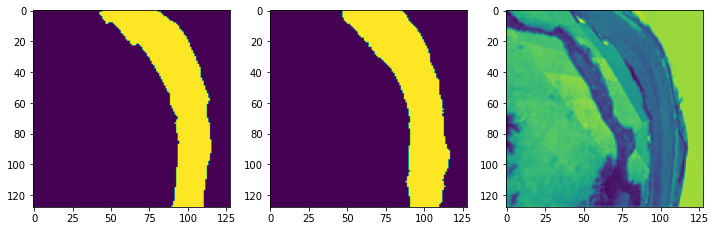

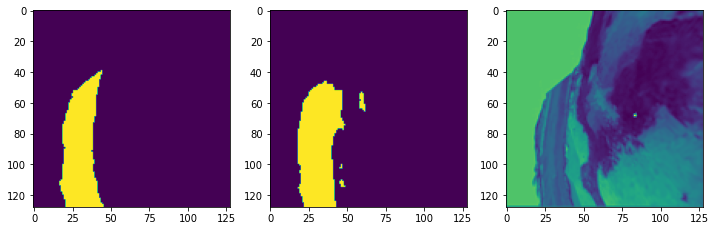

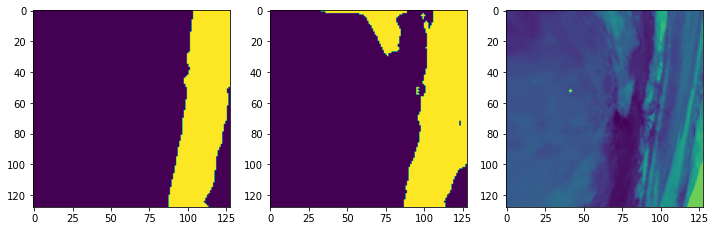

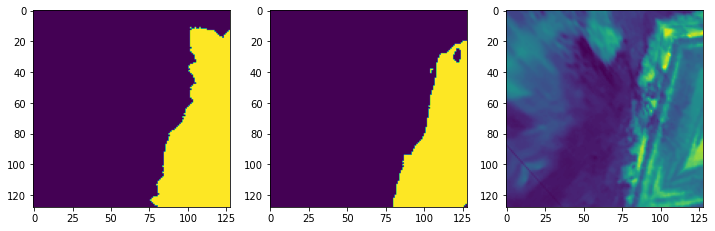

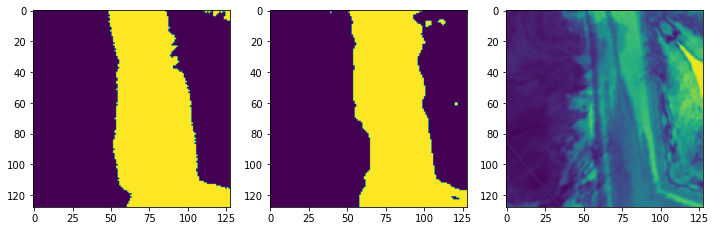

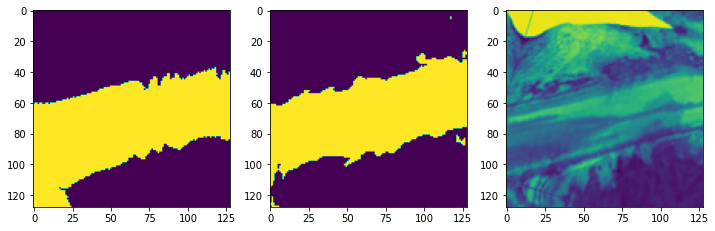

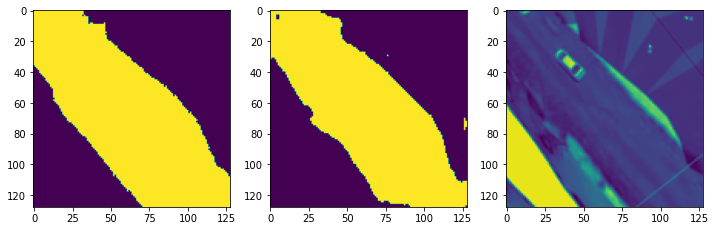

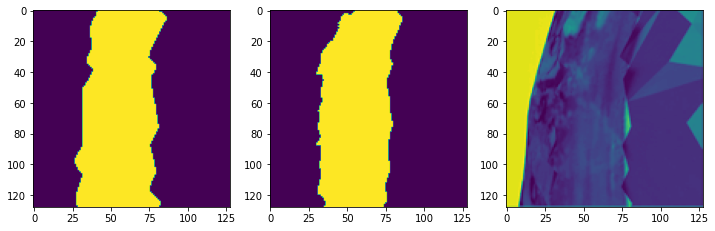

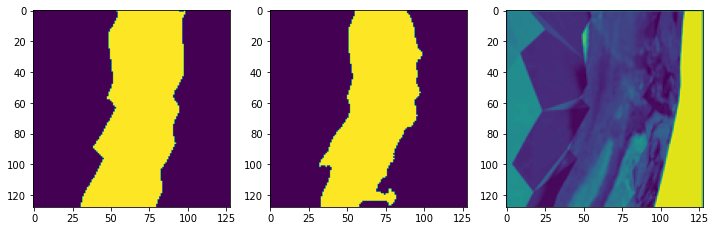

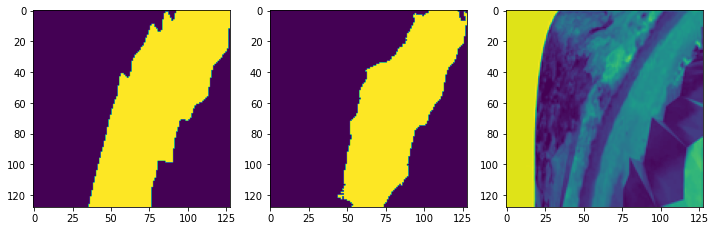

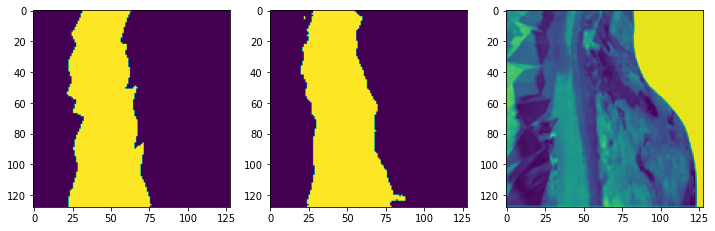

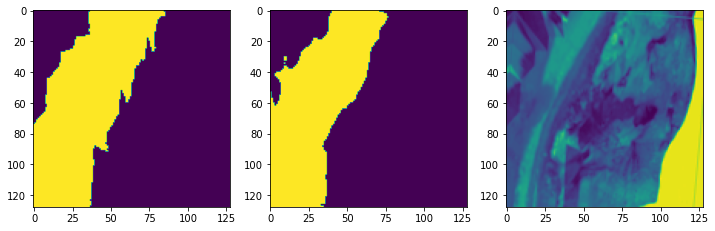

In [124]:
for i in range(72):  
    model.eval()
    ind = i
    ts = trainset[ind]
    tx = ts[0].unsqueeze(0).to(device)
    ty = ts[1]
    pred = model(tx)
    pred = (torch.sigmoid(pred) > 0.5)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(ty[:, :])
    ax[1].imshow(pred[0, 0, :, :].detach().to("cpu").squeeze())
    ax[2].imshow(tx[0, 0, :, :].to("cpu").detach().squeeze())

In [125]:
torch.save(model.state_dict(), "unet72imagestrainedweights.pt")